# Example: Surface brightness profile extraction and fitting with PyProffit  

This thread shows how to read data, extract surface brightness profiles, fit data and extract density profiles with PyProffit. 

We start by loading the packages:

In [1]:
import numpy as np
import pyproffit
import matplotlib.pyplot as plt

Then we can move to the data directory with the _os_ package. 

In [2]:
import os

# Change this to the proper directory containing your run
os.chdir('../validation/')
os.listdir()

['test_sb.fits',
 'gsb.fits',
 'expose_mask_37.fits.gz',
 'test_density.pdf',
 'test_outmod.fits',
 'test_script.py',
 '.ipynb_checkpoints',
 'test_plot_fit.pdf',
 'test_rec_stan.pdf',
 'reference_depr.fits',
 'test_save_all.fits',
 'b_37.fits.gz',
 'reference_psf.dat',
 'test_dmfilth.fits',
 'Untitled1.ipynb',
 'back_37.fits.gz',
 'reference_pymc3.dat',
 'comp_rec.pdf',
 'test_region.reg',
 'test_mgas.pdf',
 'mybeta_GP.stan',
 'reference_OP.dat',
 'Untitled.ipynb']

Now we load the data inside a _Data_ object in PyProffit structure:

In [3]:
dat=pyproffit.Data(imglink='b_37.fits.gz',explink='expose_mask_37.fits.gz',
                   bkglink='back_37.fits.gz')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


1. Here imglink=_'epic-obj-im-700-1200.fits'_ is the link to the image file (count map) to be loaded.
2. The option _explink=_'epic-exp-im-700-1200.fits' allows the user to load an exposure map for vignetting correction. In case this option is left blank, a uniform exposure of 1s is assumed for the observation.   
3. The option _bkglink=_'epic-back-oot-sky-700-1200.fits' allows to load an external background map, which will be used when extracting surface brightness profiles.

The images are then loaded into the _Data_ structure and can be easily accessed as below:

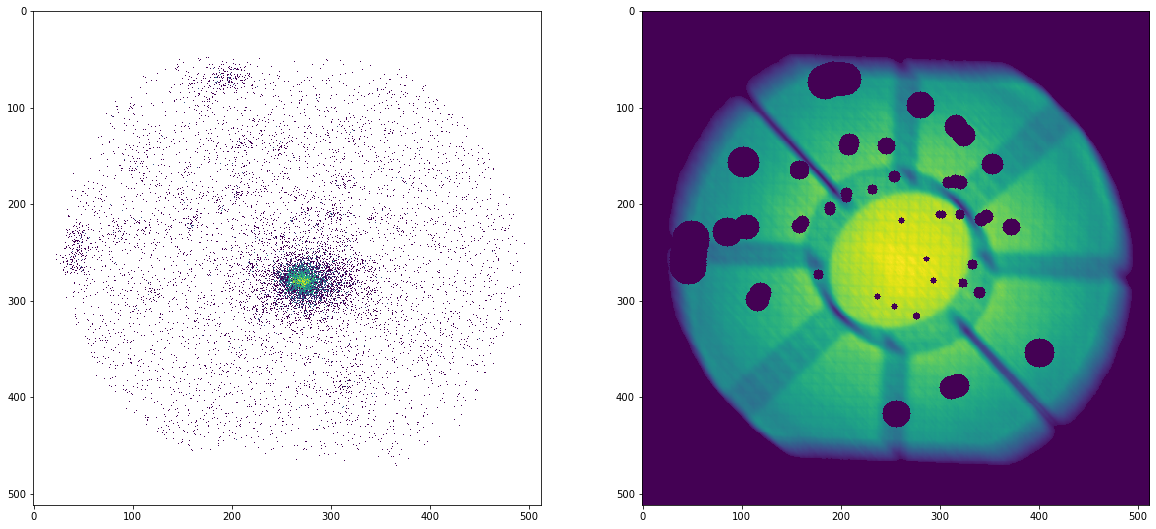

In [4]:
fig = plt.figure(figsize=(20,20))
s1=plt.subplot(221)
plt.imshow(np.log10(dat.img),aspect='auto')
s2=plt.subplot(222)
plt.imshow(dat.exposure,aspect='auto')

All the areas with zero exposure will be automatically excluded. We can ignore additional regions using the _region_ function of the _Data_ class, which loads a DS9 region file (in image or FK5 format):

In [5]:
dat.region('../tests/dmfilth.reg')

Excluded 2 sources


The exposure in the requested areas has been set to 0. Let's look at the output:

<Figure size 432x288 with 0 Axes>

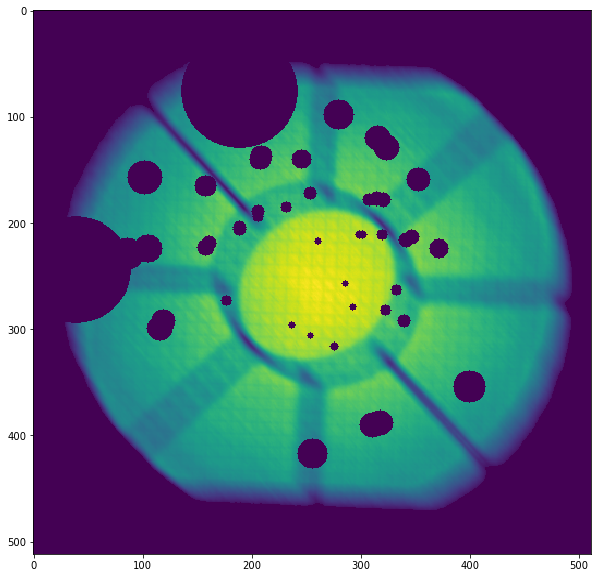

In [6]:
plt.clf()
fig = plt.figure(figsize=(10,10))
plt.imshow(dat.exposure,aspect='auto')

<h2> Profile extraction </h2>

Now we define a _Profile_ object in the following way:


In [7]:
prof=pyproffit.Profile(dat,center_choice='centroid',maxrad=45.,binsize=20.,centroid_region=30.)

Computing centroid and ellipse parameters using principal component analysis
No approximate center provided, will search for the centroid within a radius of 30 arcmin from the center of the image
Denoising image...
Running PCA...
Centroid position: 272.6956034226353 279.18237274024386
Corresponding FK5 coordinates:  55.71658679320788 -53.63576859991975
Ellipse axis ratio and position angle: 1.1208927164140738 -146.76753513469183


<h2><i>Profile</i> class options</h2>

<p>The class <i>Profile</i> is designed to contain all the Proffit profile extraction features (not all of them have been implemented yet). The "center_choice" argument specifies the choice of the center:
<blockquote>
    <p> center_choice='<i>centroid</i>': compute image centroid and ellipticity </p>
    <p> center_choice='<i>peak</i>': use brightness peak </p>
    <p> center_choice='<i>custom_fk5</i>': use custom center in FK5 coordinates (degrees), provided by the "center_ra" and "center_dec" arguments
    <p> center_choice='<i>custom_ima</i>': like <i>custom_fk5</i> but with input coordinates in image pixels
</blockquote>
</p>

The other arguments are the following:
<blockquote>
    <p> maxrad=<i>rad</i>: define the maximum radius of the profile (in arcmin) </p>
    <p> binsize=<i>size</i>: the width of the bins (in arcsec) </p>
    <p> center_ra=<i>ra</i>, center_dec=<i>dec</i>: position of the center (if center_choice='<i>custom_fk5</i>' or '<i>custom_ima</i>') </p>
    <p> binsize=<i>size</i>: minimum bin size in arcsec 
    <p> binning='<i>binning</i>': specify binnig scheme: <i>linear</i> (default), <i>log</i>, or <i>custom</i>. In the <i>custom</i> case, an array with the binning definition should be provided through the option bins=<i>array</i>
    <p> centroid_region=<i>radius</i>: for centroid calculation (center_choice=<i>centroid</i>), optionally provide a radius within which the centroid will be computed, instead of the entire image.
</blockquote>

<h3> Now let's extract the profile...</h3>

In [8]:
prof.SBprofile(ellipse_ratio=prof.ellratio,ellipse_angle=prof.ellangle+180.)

<p>Here we have extracted a profile in elliptical annuli centered on the image centroid (see above), with an ellipse axis ratio (major/minor) and position angle calculated with principal component analysis. If ellipse_ratio and ellipse_angle are left blank circular annuli are used.</p>

<blockquote>
    <p> ellipse_ratio=<i>rat</i>: the ratio of major to minor axis (a/b) of the ellipse (default=1, i.e. circular annuli) </p>
    <p> ellipse_angle=<i>angle</i>: rotation angle of the ellipse from the R.A. axis (default=0) </p>
    <p> angle_low, angle_high=<i>angle</i>: in case of profile extraction in sectors, the position angle of the minimum and maximum angles of the sector, with 0 equivalent to the R.A. axis (default=None, i.e. the entire azimuth) 
</blockquote>

<p> Now let's plot the profile...</p>

<Figure size 432x288 with 0 Axes>

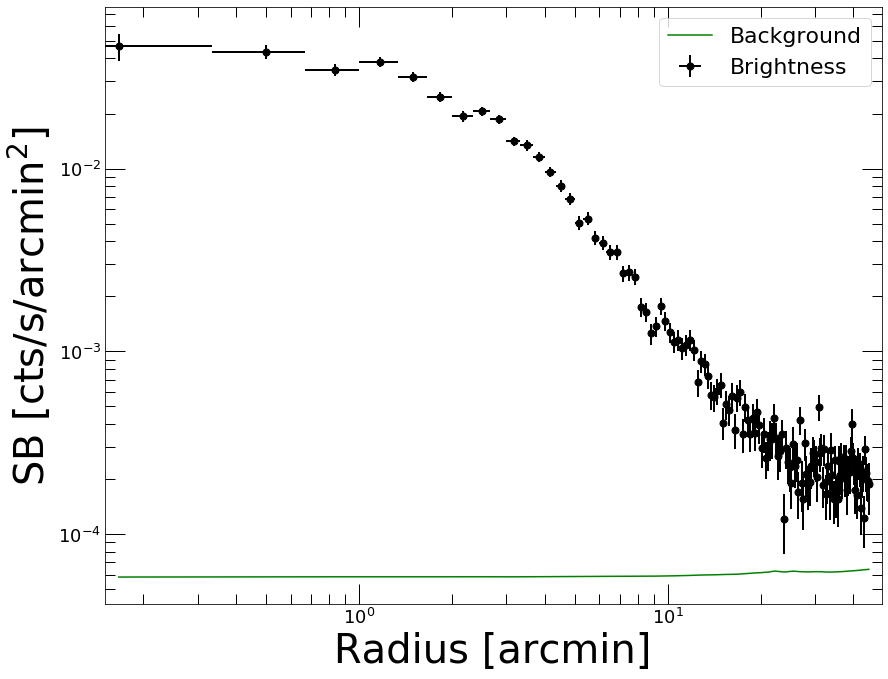

In [9]:
prof.Plot()

<h2>Defining a model</h2>

<p>Models can be defined using the <i>Model</i> class. Currently few built-in models are provided, but all the Proffit models will eventually be ported.</p>

In [10]:
mod=pyproffit.Model(pyproffit.BetaModel)

Any user-defined Python function operating on NumPy arrays can be defined here, see below.

<h2>Fitting the data</h2>

<p>To fit the extracted profiles PyProffit provides the <i>Fitter</i> class, which takes a <i>Profile</i> and a <i>Model</i> object as input:</p>

In [11]:
fitobj=pyproffit.Fitter(model=mod, profile=prof)

fitobj.Migrad(beta=0.7,rc=2.,norm=-2,bkg=-4,pedantic=False, fix_beta=True, limit_rc=(0, 10))


------------------------------------------------------------------
| FCN = 170.3                   |     Ncalls=133 (133 total)     |
| EDM = 5.78E-06 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

Here _beta_ was fixed to its input value through <i>fix_beta=True</i> option, and rc was constrained to be in the region [0,10] through the <i>limit_rc=(0,10)</i> argument.

Now we can plot the data together with the best fitting model

<Figure size 432x288 with 0 Axes>

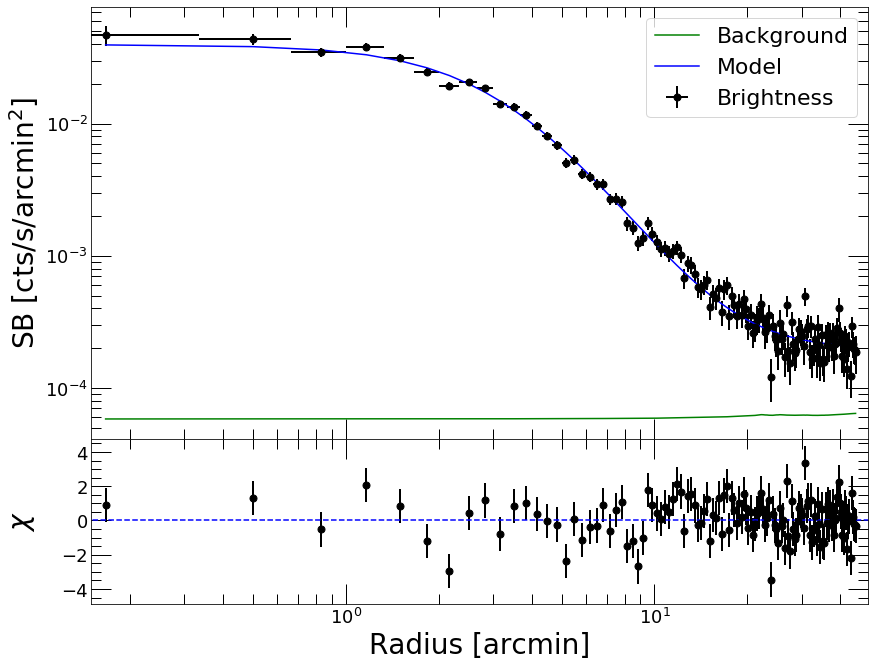

In [12]:
prof.Plot(model=mod)

<p> That's nice; now if instead of $\chi^2$ we want to fit the counts with C-stat</p>

In [13]:
fitobj.Migrad(method='cstat',beta=0.7,rc=2.,norm=-2.,bkg=-4.,pedantic=False,fitlow=0.,fithigh=30.)

------------------------------------------------------------------
| FCN = 103.5                   |     Ncalls=224 (224 total)     |
| EDM = 8.46E-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

Here we have restricted the fitting range to be between 0 and 30 arcmin through the _fitlow_ and _fithigh_ arguments. This time, _beta_ was left free while fitting.

<Figure size 432x288 with 0 Axes>

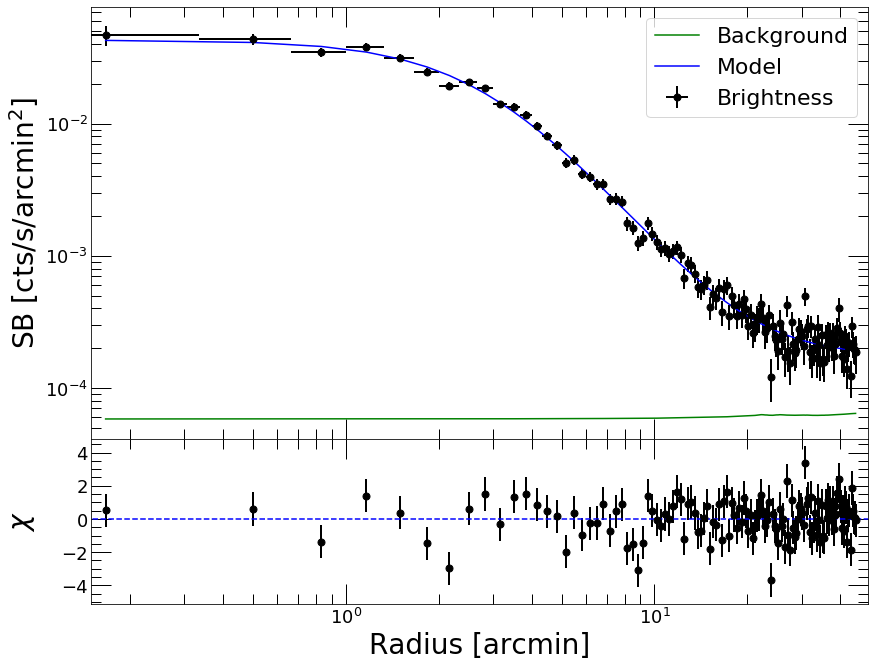

In [14]:
prof.Plot(model=mod)

Now if we want to re-extract the profile with a different binning and subtract the background...

In [15]:
p2=pyproffit.Profile(dat,center_choice='custom_ima',center_ra=prof.cx,center_dec=prof.cy,
                     maxrad=25.,binsize=20.,binning='log')

p2.SBprofile(ellipse_ratio=prof.ellratio,ellipse_angle=prof.ellangle)

Corresponding FK5 coordinates:  55.72357900571692 -53.63992702587888


<Figure size 432x288 with 0 Axes>

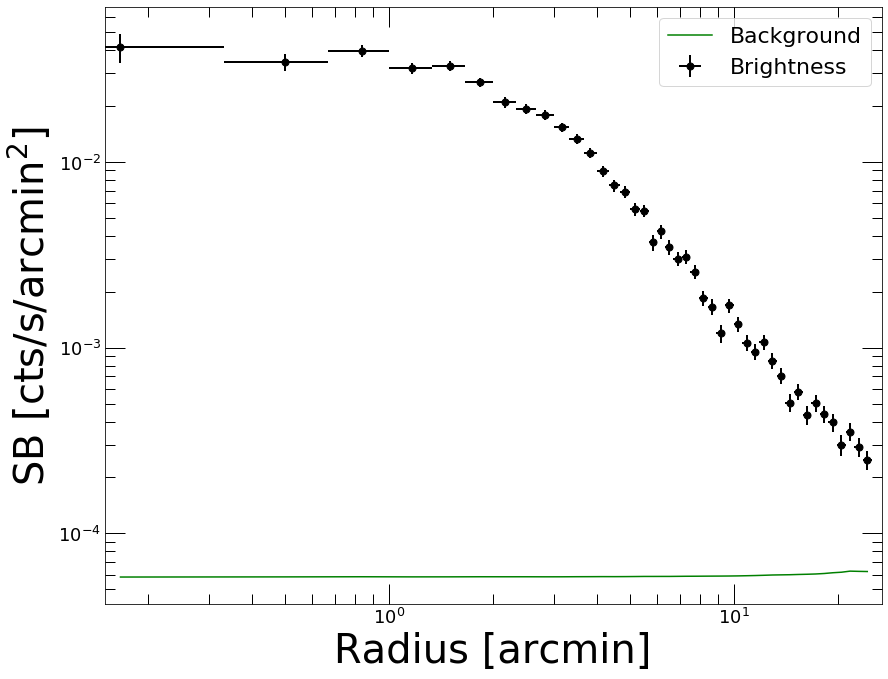

In [16]:
p2.Plot()

We will use the results of the previous fit stored in the _Fitter_ object to subtract the background. The _Backsub_ method of the _Profile_ reads the _bkg_ parameter, subtracts its value from the brightness profile and adds the statistics error in quadrature:

<Figure size 432x288 with 0 Axes>

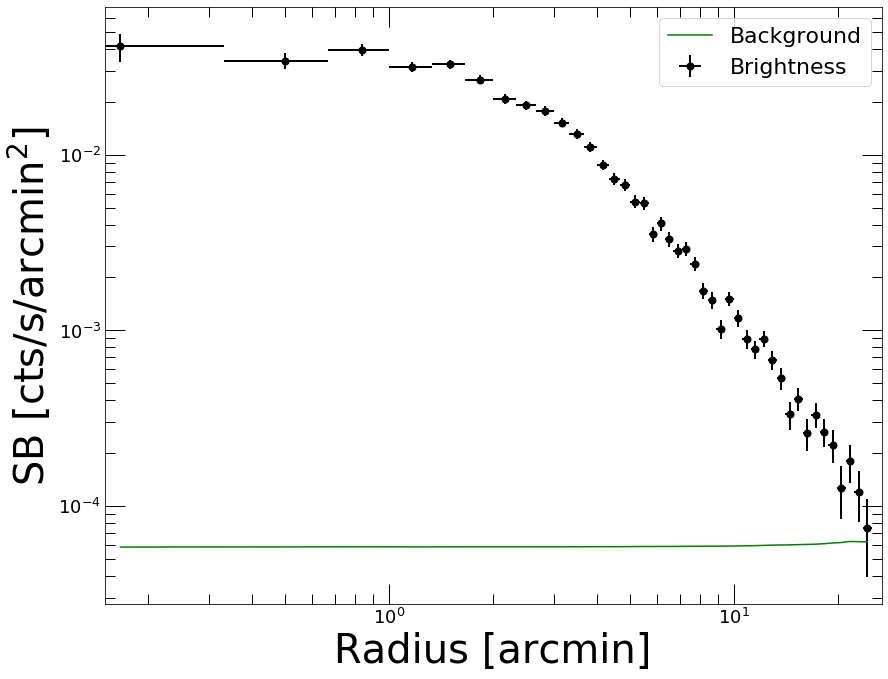

In [17]:
p2.Backsub(fitobj)
p2.Plot()

<h2> Fitting with a custom function</h2>

<p>To fit the data with any custom function we can simply define a Python function with the desired model and pass it to a PyProffit <i>Model</i> object, with the following structure:</p>

In [18]:
# Create your own model, here some sort of cuspy beta model

def myModel(x,beta,rc,alpha,norm,bkg):
    term1 = np.power(x/rc,-alpha) * np.power(1. + (x/rc) ** 2, -3 * beta + alpha/2.)
    n2 = np.power(10., norm)
    b2 = np.power(10., bkg)
    return n2 * term1 + b2

In [19]:
# Pass the user-defined function to a new Model structure

cuspmod = pyproffit.Model(myModel)

Now we fit the model to the data, as done previously. 

We can also fix the value of some of the parameters to help the convergence. This is done easily with the <i>fix_par=True</i> option, where _par_ is the name of the parameter.

In [25]:
fitvik=pyproffit.Fitter(model=cuspmod, profile=prof)
fitvik.Migrad(beta=0.35, rc=1., alpha=0., norm=-1.7, bkg=-3.8,
              pedantic=False)

------------------------------------------------------------------
| FCN = 162.9                   |     Ncalls=672 (672 total)     |
| EDM = 7.19E-07 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------

<Figure size 432x288 with 0 Axes>

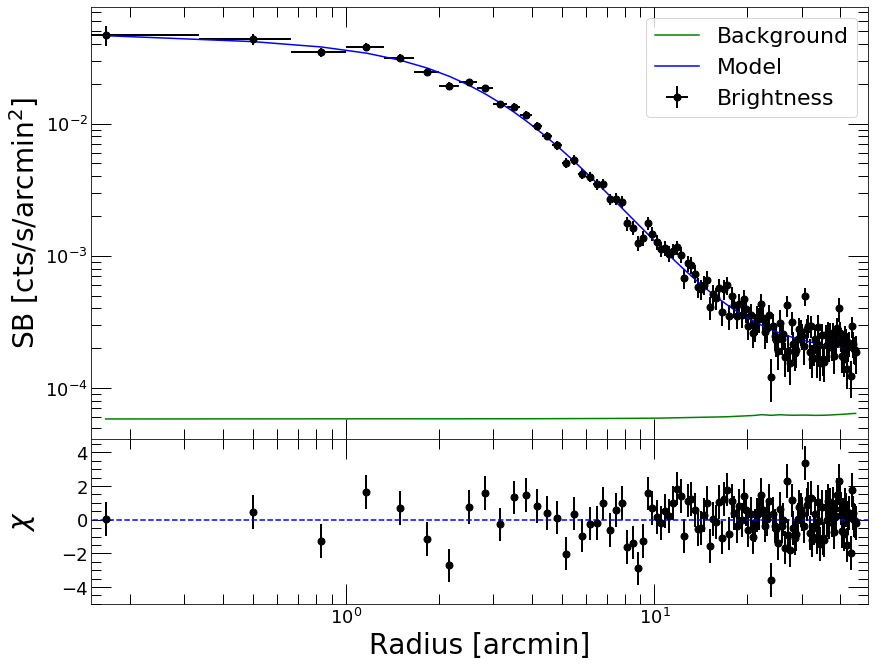

In [26]:
prof.Plot(model=cuspmod)

<h2>Deprojection</h2>

<p>For deprojection, PyProffit implements both the standard onion-peeling deprojection similar to that of plain Proffit and a new method based on multiscale decomposition of the observed profile. The new method is suitable in the low count-rate regime, provides on-the-fly propagation of the background value and PSF deconvolution.</p>

<p>The two methods can be accessed with the <i>Deproject</i> class. For the extraction of density profiles the class requires the following input:
<blockquote>
    <p>profile=<i>prof</i>: a <i>Profile</i> object containing the data
    <p>z=<i>redshift</i>: the redshift of the source
    <p>cf=<i>factor</i>: the conversion between count rate and emission measure (same as in classical Proffit)</p>
</blockquote>
</p>

In [23]:
factor = 30.05 # Conversion between MOS1 count rate and emission measure, to be recomputed for each cluster
redshift = 0.312
depr = pyproffit.Deproject(z=redshift,cf=factor,profile=prof)

Let's start with the multiscale decomposition method. It can be launched with the _Multiscale_ function of the _Deproject_ class. The parameters of the function are the following:

<blockquote>
    <p>nmcmc=<i>1000</i>: number of points in Hamiltonian Monte Carlo chain</p>
    <p>bkglim=<i>rad</i>: radius beyond which it is assumed that the source is 0 (i.e. background only)
    </p>
    <p>samplefile=<i>file.dat</i>: output file where the HMC samples will be stored</p>
</blockquote>
    
The sampling time with HMC will depend on a number of factors, including the number of bins in the profile, the number of points in the output chain, and the bkglim value.

In [24]:
depr.Multiscale(nmcmc=1000,bkglim=30.)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running MCMC...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bkg, coefs]
Sampling 4 chains, 288 divergences: 100%|██████████| 6000/6000 [04:08<00:00, 24.15draws/s]
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some paramet

Done.
 Total computing time is:  4.193644936879476  minutes


<Figure size 432x288 with 0 Axes>

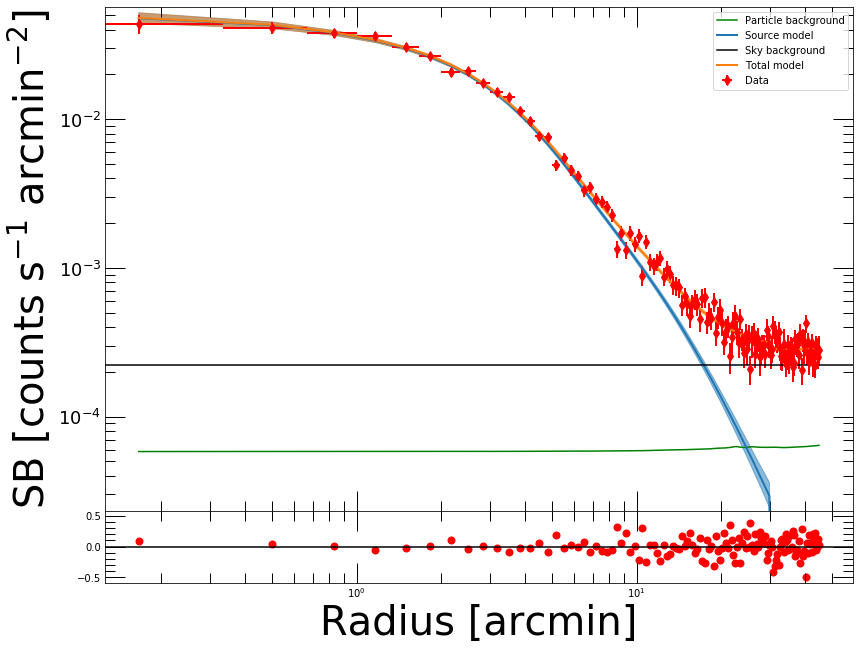

In [25]:
depr.PlotSB()

Here we were using the default PyMC3 backend for optimization. If instead we want to use the Stan backend:

In [26]:
depr_stan = pyproffit.Deproject(z=redshift,cf=factor,profile=prof)
depr_stan.Multiscale(backend='stan',nmcmc=1000,bkglim=30.,samplefile='test_sample_stan.dat')

Using cached StanModel
Running MCMC...
Done.
 Total computing time is:  0.8765543580055237  minutes


To extract the density profile from the deprojected data, just run the Density() function from the Deproject class:

<Figure size 432x288 with 0 Axes>

/usr/lib/python3/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


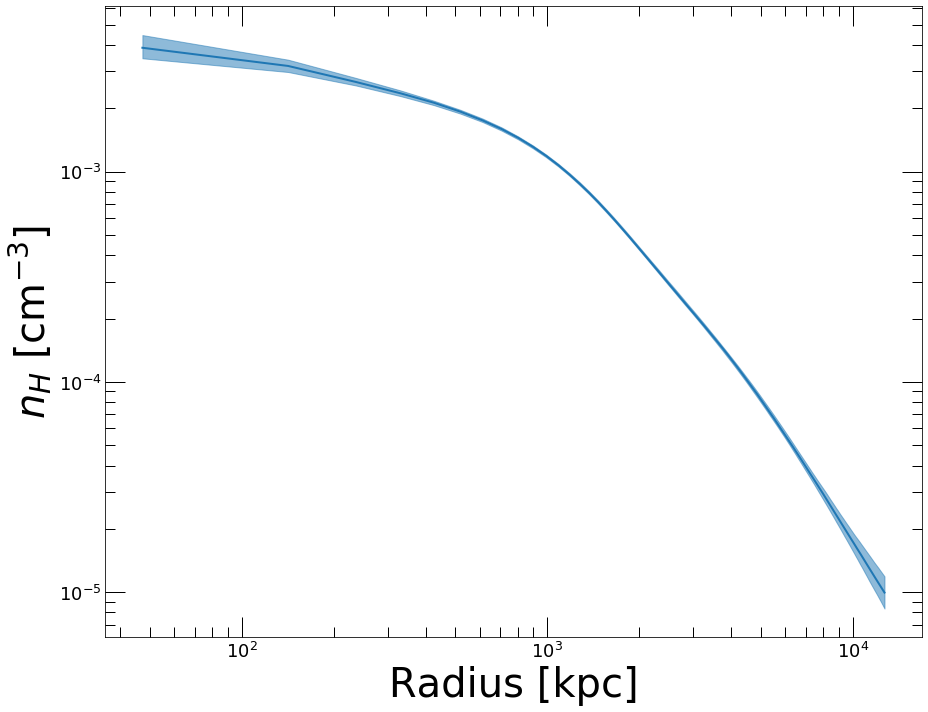

In [27]:
depr_stan.Density()
depr_stan.PlotDensity()

The standard <i>onion peeling</i> profile can be computed using the <i>OnionPeeling</i> function of the _Deproject_ class. Here the input profile should be background subtracted first.

In [28]:
depr_op = pyproffit.Deproject(z=redshift,cf=factor,profile=p2)

depr_op.OnionPeeling()

<Figure size 432x288 with 0 Axes>

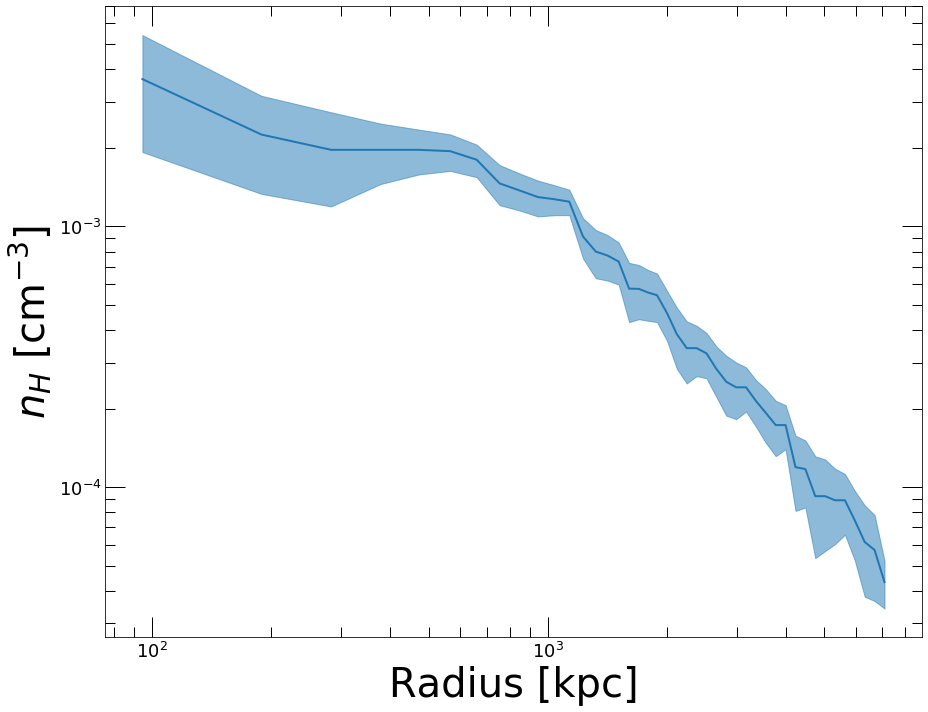

In [29]:
#depr_op.Density()
depr_op.PlotDensity()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<Figure size 432x288 with 0 Axes>

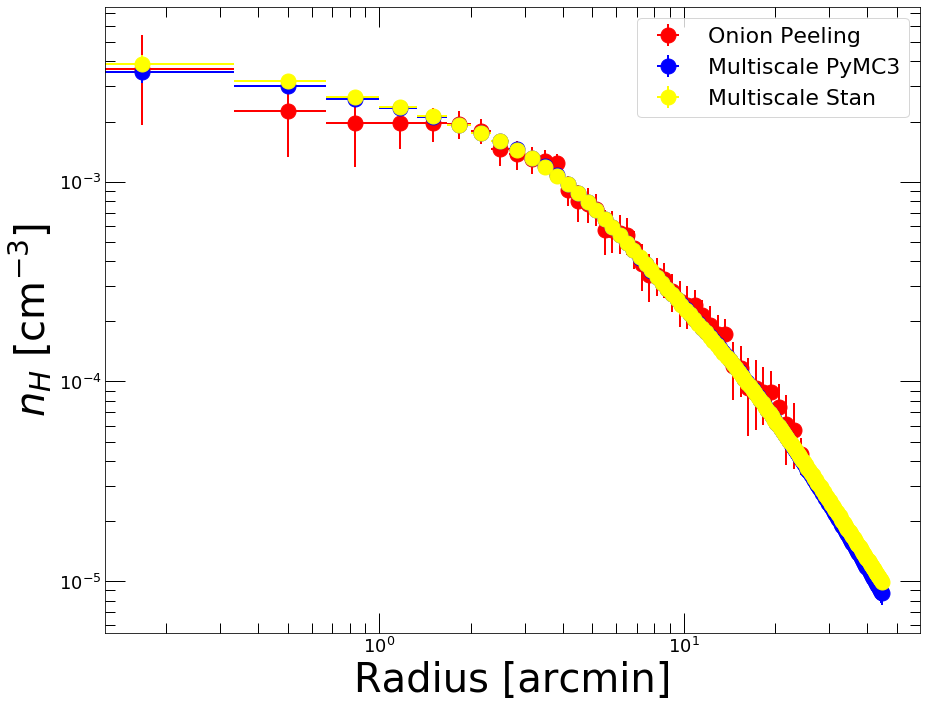

In [30]:
depr.Density()

plt.clf()
fig=plt.figure(figsize=(13,10))
ax_size = [0.1, 0.1,
          0.87, 0.87]
ax = fig.add_axes(ax_size)
axbox = ax.get_position()
ax.minorticks_on()
ax.tick_params(length=20, width=1, which='major', direction='in', right='on', top='on')
ax.tick_params(length=10, width=1, which='minor', direction='in', right='on', top='on')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
plt.xlabel('Radius [arcmin]',fontsize=40)
plt.ylabel('$n_{H}$ [cm$^{-3}$]',fontsize=40)
plt.xscale('log')
plt.yscale('log')
plt.errorbar(p2.bins,depr_op.dens,xerr=p2.ebins,yerr=depr_op.dens-depr_op.dens_lo,fmt='o',color='red',elinewidth=2,markersize=15,capsize=0,
             mec='red',label='Onion Peeling')
plt.errorbar(prof.bins,depr.dens,xerr=prof.ebins,yerr=depr.dens-depr.dens_lo,fmt='o',color='blue',elinewidth=2,markersize=15,capsize=0,
             mec='blue',label='Multiscale PyMC3')
plt.errorbar(prof.bins,depr_stan.dens,xerr=prof.ebins,yerr=depr_stan.dens-depr_stan.dens_lo,fmt='o',color='yellow',elinewidth=2,markersize=15,capsize=0,
             mec='yellow',label='Multiscale Stan')
plt.legend(fontsize=22)


The multiscale decomposition results can also be used to measure count rates in various apertures and gas masses, in the following way:

<blockquote>
    <p> Deproject.CountRate(<i>xmin</i>,<i>xmax</i>): Integrate the count rate between <i>xmin</i> and <i>xmax</i>. Returns the median count rate and the </p>
    <p> Deproject.Mgas(<i>radius</i>): Calculate the cumulative gas mass within <i>radius</i> (in kpc)
    </p>
    </blockquote>
    

Reconstructed count rate: 1.79801 (1.77162 , 1.82541)


<Figure size 432x288 with 0 Axes>

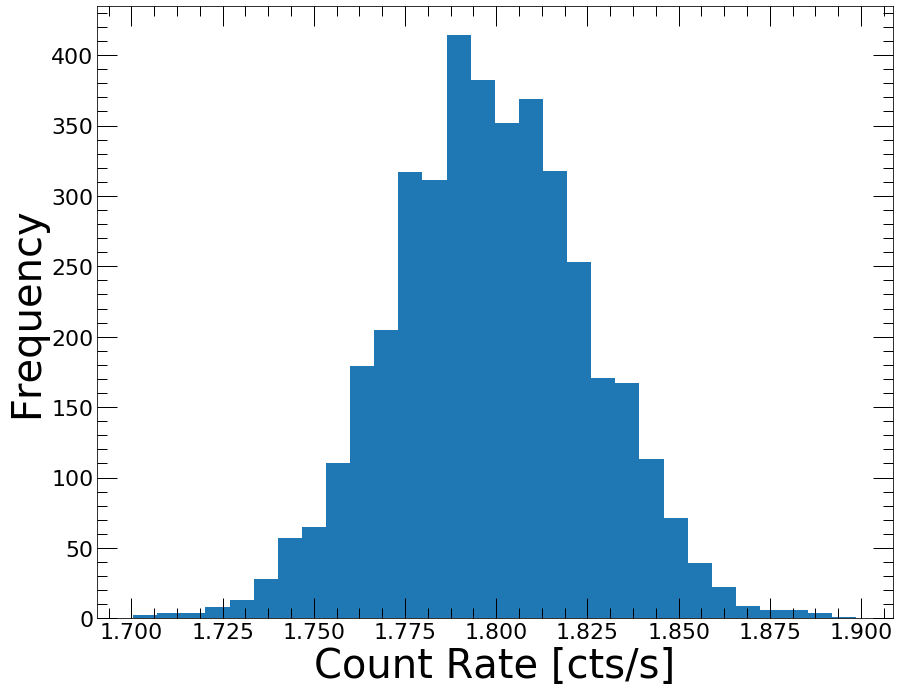

In [31]:
cr,crl,crh=depr.CountRate(0.,10.)

<Figure size 432x288 with 0 Axes>

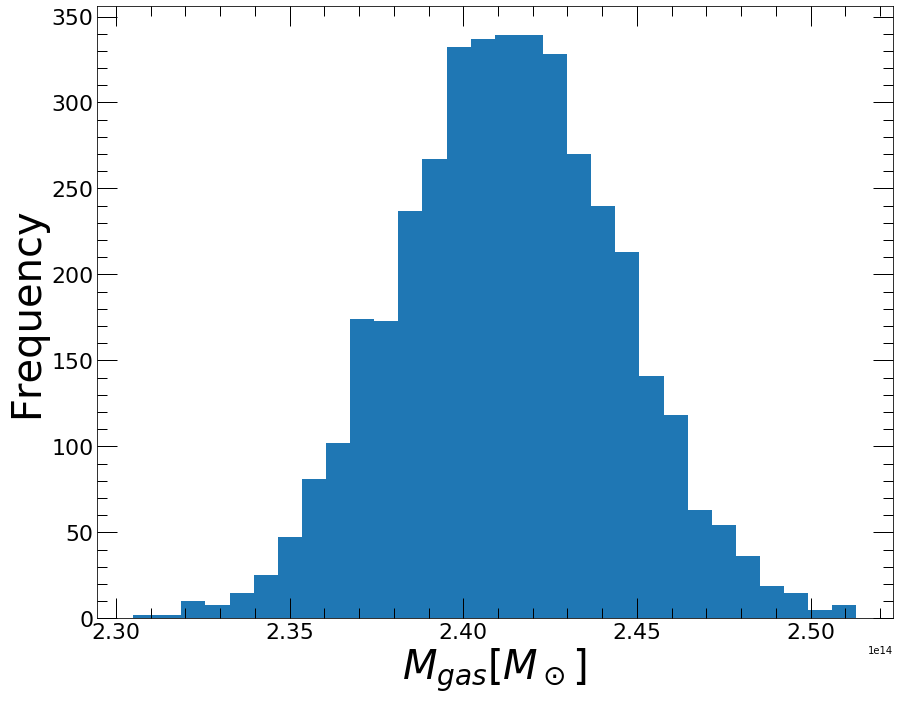

In [32]:
mg,mgl,mgh=depr.Mgas(1000.)

(135,) (135,)
